In [ ]:
%pip install pytesseract pillow 
%pip install opencv-python




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 3.8 MB/s eta 0:00:10
   - -------------------------------------- 1.6/39.0 MB 3.7 MB/s eta 0:00:11
   -- ------------------------------------- 2.4/39.0 MB 3.8 MB/s eta 0:00:10
   --- ------------------------------------ 3.4/39.0 MB 4.0 MB/s eta 0:00:09
   ---- ----------------------------------- 4.2/39.0 MB 4.3 MB/s eta 0:00:09
   ----- ---------------------------------- 5.2/39.0 MB 4.4 MB/s eta 0:00:08
   ------ --------------------------------- 6.3/39.0 MB 4.5 MB/s eta 0:00:08
   ------- -------------------------------- 7.1/39.0 MB 4.5 MB/s eta 0:00:08
   -------- ------------------------------- 8.1/39.0 MB 4.4 MB/s eta 0:00:07
   --------- --

In [16]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from PIL import Image
import pytesseract

# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"



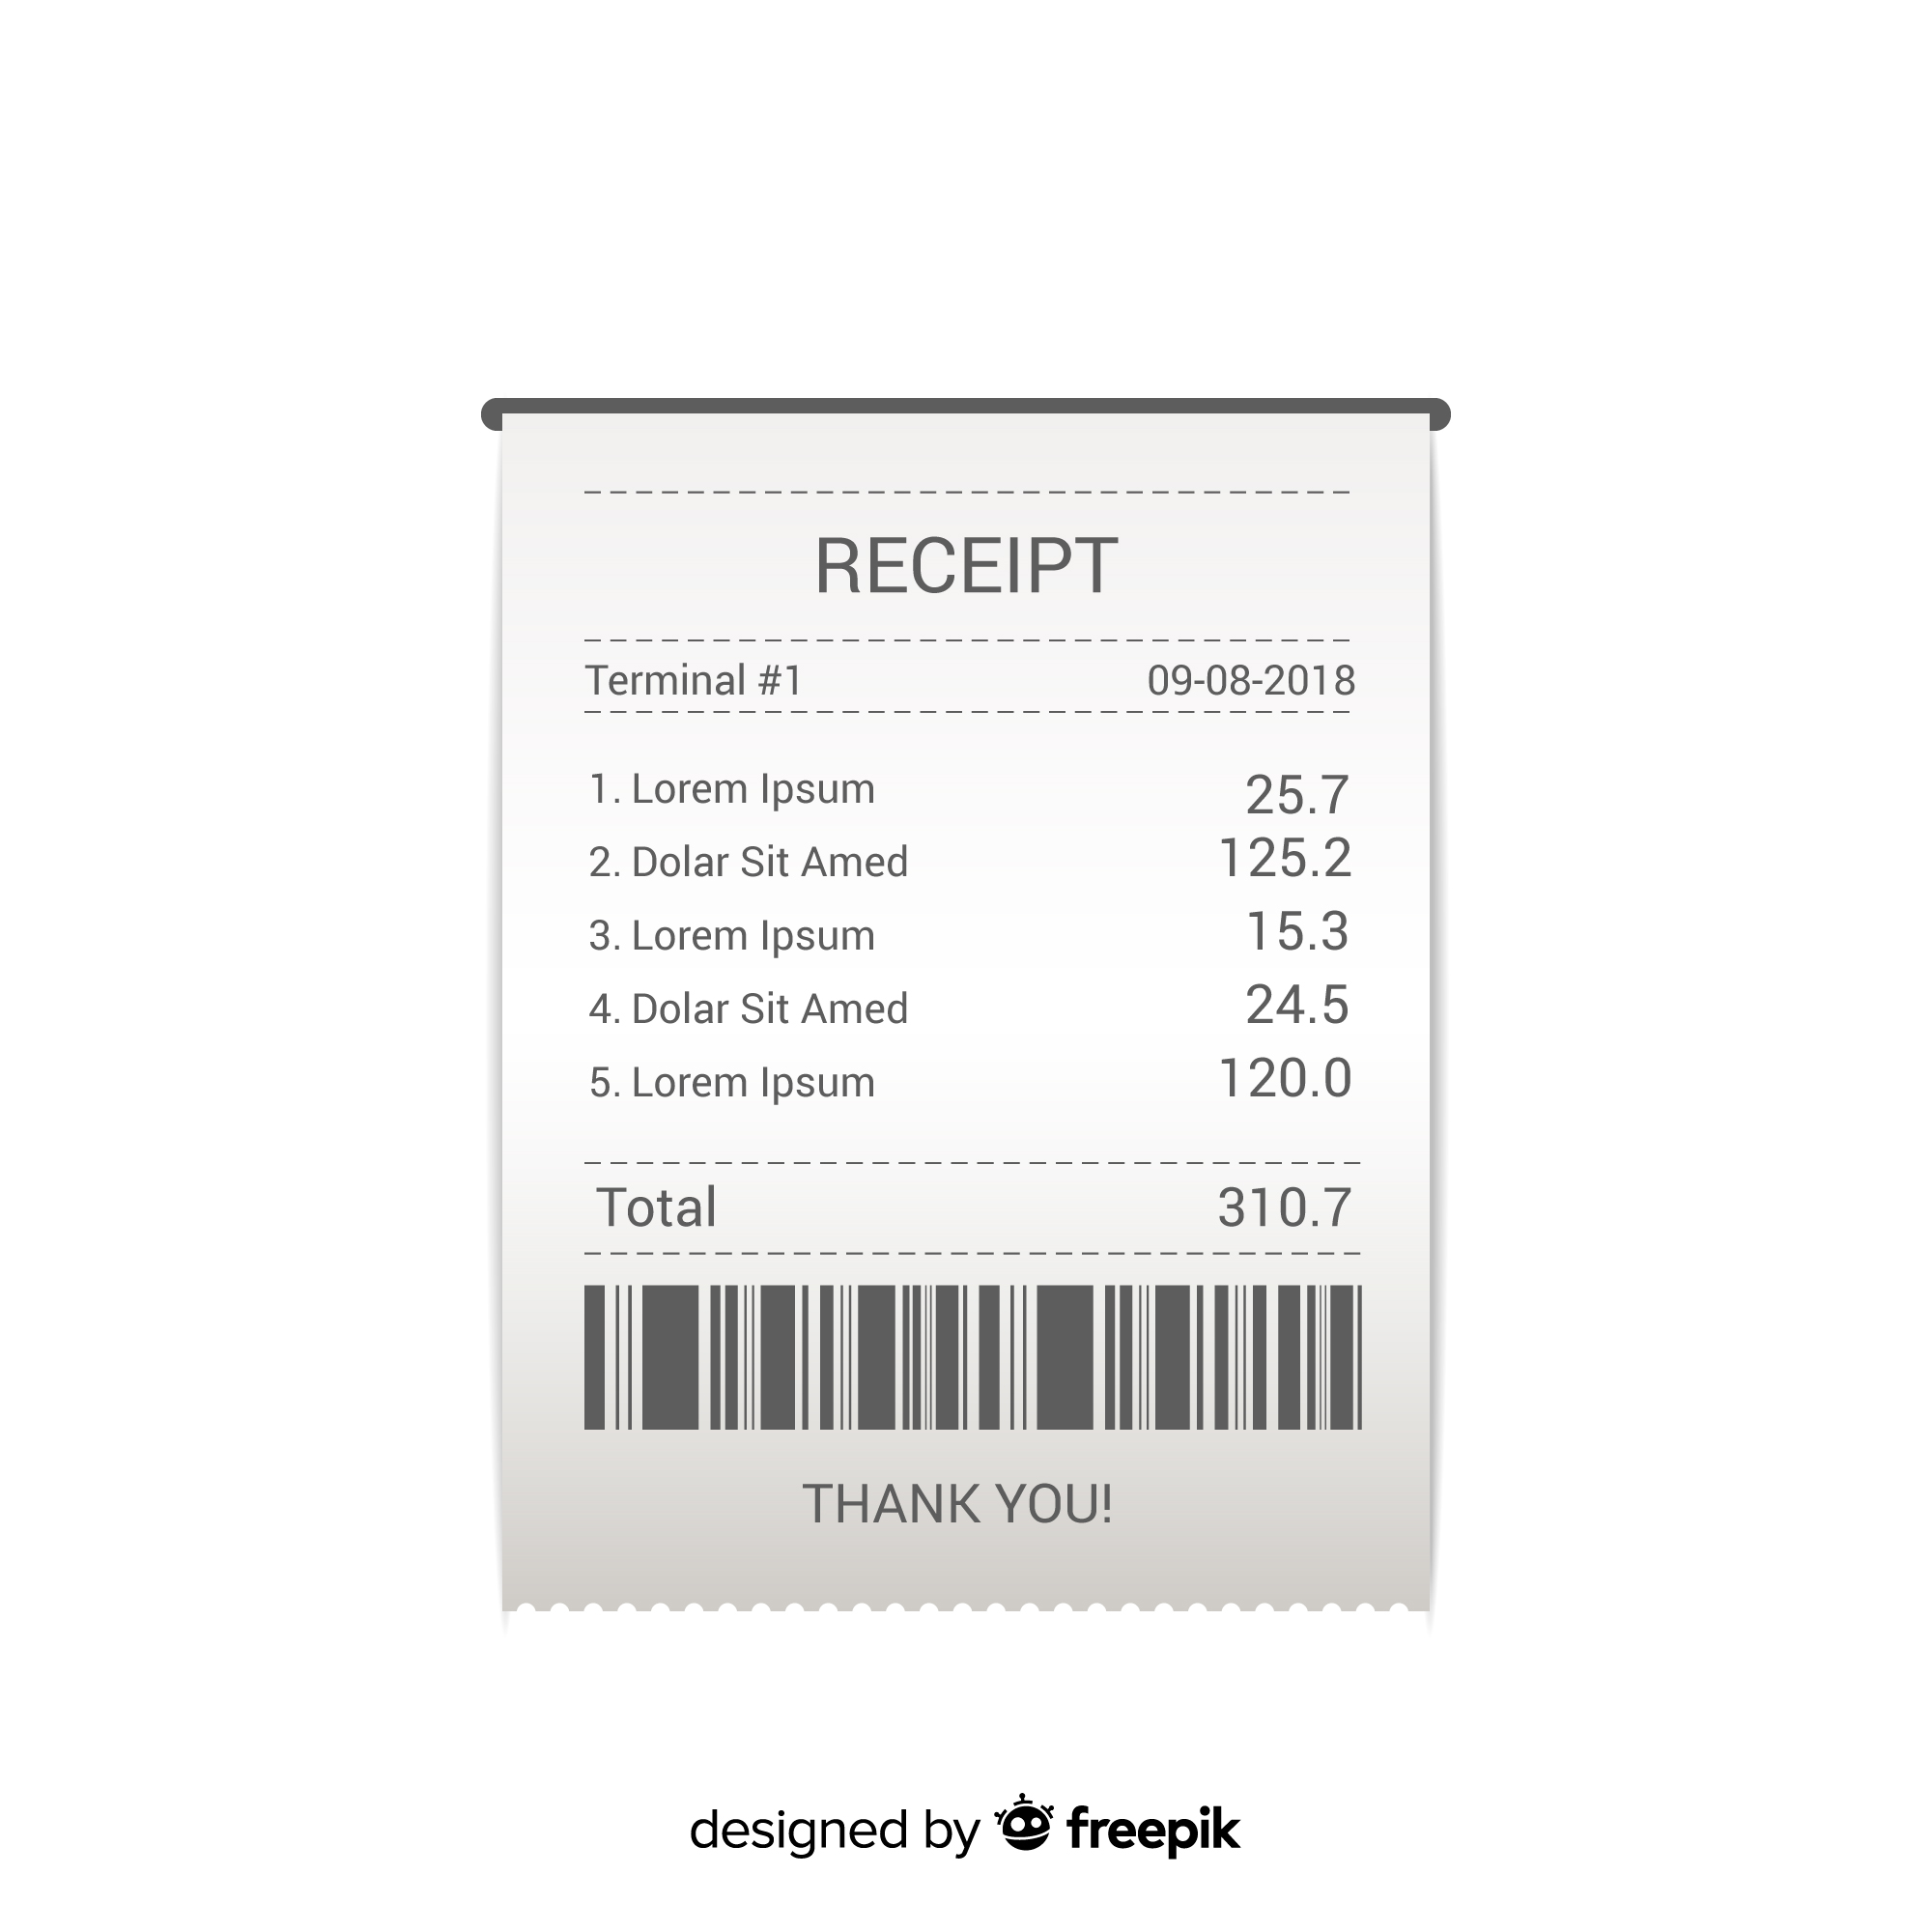

In [21]:
from IPython.display import Image as IPImage

# Display the image in the notebook
IPImage('receipt.jpg')


In [20]:
from PIL import Image
import pytesseract

# If Tesseract isn't on PATH, uncomment and set the correct path:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

img = Image.open(r"C:\Users\HP\OneDrive\Desktop\OCR\myproject\receipt.jpg")
gray_image = img.convert("L")

text = pytesseract.image_to_string(gray_image, lang="eng")
print(text)

RECEIPT
Terminal #) ; 09-08-2018
1. Lorem Ipsum 25.7
2. Dolar Sit Amed 125.2
3. Lorem Ipsum 15.3
4. Dolar Sit Amed 24.5
5. Lorem Ipsum 120.0
Total 7 310.7

THANK YOU!

designed by ® freepik



In [17]:
# --- Robust Receipt OCR & Parsing (Tesseract + OpenCV) ---
# Install dependencies if missing:
# pip install opencv-python pillow pytesseract numpy

import re, json, time
from pathlib import Path

import cv2
import numpy as np
from PIL import Image
import pytesseract

# If Tesseract isn't on PATH, set the correct path:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

IMG_PATH = r"C:\Users\HP\OneDrive\Desktop\OCR\myproject\receipt.jpg"  # set your path

# ---------- OCR helpers ----------
_CURRENCY = r"[-+]?\$?\s*\d{1,3}(?:[,\s]\d{3})*(?:\.\d{2})?"
_NUM_RE = re.compile(_CURRENCY)
_DATE_RES = [
    re.compile(r"\b(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4})\b"),                   # 12/31/2024, 12-31-24
    re.compile(r"\b(?:\d{4}[-/]\d{1,2}[-/]\d{1,2})\b"),                     # 2024-12-31
    re.compile(r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)\.?\s+\d{1,2},\s*\d{2,4}\b", re.I),
]
_TOTAL_KEYS = [
    r"amount\s*due", r"total\s*due", r"\bgrand\s*total\b",
    r"\btotal\b", r"balance\s*due", r"final\s*total"
]
_SUBTOTAL_KEYS = [r"sub\s*total", r"subtotal"]
_TAX_KEYS = [r"sales?\s*tax", r"\btax\b", r"gst", r"vat"]

def _read_bgr(path: str):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

def _preprocess_variants(img_bgr):
    # upscale to help small text
    up = cv2.resize(img_bgr, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(up, cv2.COLOR_BGR2GRAY)

    variants = []
    variants.append(("gray", gray))
    variants.append(("bilateral", cv2.bilateralFilter(gray, 7, 50, 50)))
    variants.append(("clahe", cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)).apply(gray)))

    # Thresholds
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, otsu_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    variants.append(("otsu", otsu))
    variants.append(("otsu_inv", otsu_inv))
    variants.append(("adaptive", cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 7)))

    # Slight morph to join broken characters
    kernel = np.ones((2,2), np.uint8)
    variants.append(("morph_open", cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations=1)))

    return variants

# Multiple PSMs to try
_TESS_CONFIGS = [
    "--oem 3 --psm 6 -l eng",     # Assume a block of text
    "--oem 3 --psm 4 -l eng",     # Block of text, multiple columns
    "--oem 3 --psm 11 -l eng",    # Sparse text
]

def _ocr_get_lines(img):
    # returns list of non-empty lines
    best_txt = ""
    best_score = -1
    best_lines = []
    for cfg in _TESS_CONFIGS:
        txt = pytesseract.image_to_string(img, config=cfg)
        lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]
        score = len(lines)
        if score > best_score:
            best_score = score
            best_txt = txt
            best_lines = lines
    return best_txt, best_lines

def _find_amount_on_line(line: str):
    nums = _NUM_RE.findall(line)
    return nums[-1].replace(" ", "") if nums else None

def _find_by_keywords(lines, patterns):
    # Return first match with its amount and line index
    for i, ln in enumerate(lines):
        low = ln.lower()
        for pat in patterns:
            if re.search(pat, low):
                amt = _find_amount_on_line(ln)
                if amt:
                    return {"label": pat, "value": amt, "index": i, "line": ln}
    return None

def _extract_date(lines):
    for ln in lines[:20]:  # top lines usually contain date
        for rex in _DATE_RES:
            m = rex.search(ln)
            if m:
                return m.group(0)
    # fallback anywhere
    for ln in lines:
        for rex in _DATE_RES:
            m = rex.search(ln)
            if m:
                return m.group(0)
    return None

def _extract_merchant(lines):
    # Pick first plausible name-like line near the top (ignore all-caps “RECEIPT”, phone, web, address-heavy lines)
    top = lines[:8]
    for ln in top:
        if len(ln) < 3: 
            continue
        if re.search(r"\b(receipt|invoice|order|transaction|store|market)\b", ln, re.I):
            continue
        if re.search(r"https?://|www\.", ln, re.I):
            continue
        if re.search(r"\d{3}[-\s]?\d{3}[-\s]?\d{4}", ln):  # phone
            continue
        if re.search(r"\d", ln) and len(ln.split()) > 6:  # likely address line
            continue
        # If seems name-like (letters, few words)
        words = ln.split()
        if 1 <= len(words) <= 5:
            return ln
    # fallback: first line
    return top[0] if top else None

def _is_likely_item_line(ln: str):
    # Heuristic: ends with a price and has at least a word before
    if not _NUM_RE.search(ln):
        return False
    # must end or near end with a number
    tail_num = _find_amount_on_line(ln)
    if not tail_num:
        return False
    # Exclude lines that contain keywords for totals
    low = ln.lower()
    if any(k in low for k in ["subtotal", "sub total", "tax", "total", "amount due", "balance", "change", "tender", "cash", "credit"]):
        return False
    # require some alpha chars before the number
    before = ln.rsplit(tail_num, 1)[0]
    return bool(re.search(r"[A-Za-z]", before))

def _extract_items(lines, stop_index_candidates):
    # Look between header and totals region; stop before the earliest totals line if available
    stop_idx = min(stop_index_candidates) if stop_index_candidates else len(lines)
    # Skip the very top 3 lines (logo/merchant header)
    search_lines = lines[3:stop_idx]

    items = []
    for ln in search_lines:
        if _is_likely_item_line(ln):
            amt = _find_amount_on_line(ln)
            desc = ln.rsplit(amt, 1)[0].strip() if amt else ln
            # cleanup desc (remove leading qty like "2 x", etc.)
            desc = re.sub(r"^\s*\d+\s*[xX]\s*", "", desc).strip()
            items.append({"description": desc, "amount": amt})
    return items

def ocr_receipt(path: str):
    img_bgr = _read_bgr(path)
    variants = _preprocess_variants(img_bgr)

    best = {"score": -1, "lines": [], "name": "", "text": ""}
    results_per_variant = []

    for name, proc in variants:
        txt, lines = _ocr_get_lines(proc)
        # score on how many signals we can extract (totals+tax+subtotal count)
        sig = 0
        if _find_by_keywords(lines, _TOTAL_KEYS): sig += 2
        if _find_by_keywords(lines, _TAX_KEYS): sig += 1
        if _find_by_keywords(lines, _SUBTOTAL_KEYS): sig += 1
        sig += min(10, len([ln for ln in lines if _is_likely_item_line(ln)]))  # items help score too

        results_per_variant.append((name, lines, sig, txt))
        if sig > best["score"]:
            best = {"score": sig, "lines": lines, "name": name, "text": txt}

    lines = best["lines"]

    merchant = _extract_merchant(lines)
    date_str = _extract_date(lines)

    subtotal = _find_by_keywords(lines, _SUBTOTAL_KEYS)
    tax = _find_by_keywords(lines, _TAX_KEYS)
    total = _find_by_keywords(lines, _TOTAL_KEYS)

    stop_idxs = [x["index"] for x in [subtotal, tax, total] if x]
    items = _extract_items(lines, stop_idxs)

    out = {
        "meta": {
            "preprocess_variant": best["name"],
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        },
        "merchant": merchant,
        "date": date_str,
        "totals": {
            "subtotal": subtotal["value"] if subtotal else None,
            "tax": tax["value"] if tax else None,
            "total": total["value"] if total else None,
        },
        "items": items,
        "raw_preview_first_40_lines": lines[:40],
    }
    return out

result = ocr_receipt(IMG_PATH)
print(json.dumps(result, indent=2, ensure_ascii=False))

{
  "meta": {
    "preprocess_variant": "gray",
    "timestamp": "2025-09-16 14:49:33"
  },
  "merchant": "GOURMET COFFEE",
  "date": "4/09/2019",
  "totals": {
    "subtotal": null,
    "tax": "68",
    "total": null
  },
  "items": [
    {
      "description": "TABLE",
      "amount": "3"
    }
  ],
  "raw_preview_first_40_lines": [
    "GOURMET COFFEE",
    "ADDRESS, STREET LOCATION",
    "= LS LS &S_ N&S=_&_sae_ eS 8 E00 EE EE EE EL EES SSS",
    "4/09/2019 8:36:18 AM",
    "TABLE 3",
    "HOST : JAMES",
    "TAX INVOICE : ABN : 11346093268",
    "QTY",
    "DESC",
    "AMT",
    "a 58 a 5 Ss SS SS SS SS SS",
    "CAPUCCINO",
    "$5.40",
    "CHOCOLATE DONUT",
    "$8.13",
    "CAESAR SALAD",
    "$ 23 . 38",
    "ICED TEA",
    "$4.60",
    "|",
    "BER EEEESs",
    "SUBTOTAL",
    "SA} SL",
    "BEE E EEE",
    "el",
    "ees",
    "SALE TAX",
    "$3.10",
    "EeREEE Ss",
    "_",
    "ee ee",
    "BEeeEEE Ss",
    "BeEEEE Es",
    "AMOUNT",
    "$44. 61",
    "EEREeEEaEEaE sé